In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() # interactive mode

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_transforms = {
    'train': transforms.Compose([
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip( ),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/My Drive/dataset_m12_preprocessing'

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_size = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


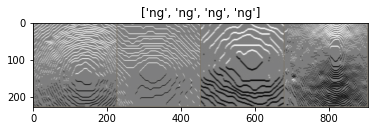

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title = [class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict( ))
  best_acc = 0.0

  loss_history = {'train': [], 'test': []}
  acc_history = {'train': [], 'test': []}

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-'*10)
    for phase in ['train', 'test']:
      if phase == 'train':
        scheduler.step()
        model.train( )
      else:
        model.eval( )

      running_loss = 0.0
      running_correts = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad( )
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          if phase == 'train':
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_correts += torch.sum(preds == labels.data)
      epoch_loss = running_loss / dataset_size[phase]
      epoch_acc = running_correts.double() / dataset_size[phase]
      
      loss_history[phase].append(epoch_loss)
      acc_history[phase].append(epoch_acc)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      if phase == 'test' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    print()
    
  time_elapsed = time.time() - since
  print('학습 완료 걸린시간: {:.0f}분 {:.0f}초'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best test Acc: {:.4f}'.format(best_acc))
  model.load_state_dict(best_model_wts)

  return model, loss_history, acc_history

In [ ]:
def visualize_model(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images // 2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far ==num_images:
          model.train(mode = was_training)
          return
      model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True) #사전 학습된 ResNet18 가져오기
num_ftrs = model_ft.fc.in_features #모델에서 feature extraction 후, FC층에 입력되는 특징 수
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device) #cpu나 GPU에 model_ft를 할당
criterion = nn.CrossEntropyLoss()

#모든 파라미터를 학습
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

#매 7 에포크 마다 학습률 0.1배 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft, loss_ft, acc_ft  = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.3500 Acc: 0.8685
test Loss: 0.3845 Acc: 0.8767

Epoch 1/24
----------
train Loss: 0.3202 Acc: 0.8764
test Loss: 0.5502 Acc: 0.8767

Epoch 2/24
----------
train Loss: 0.2562 Acc: 0.9002
test Loss: 0.7381 Acc: 0.9315

Epoch 3/24
----------
train Loss: 0.2507 Acc: 0.9128
test Loss: 0.7260 Acc: 0.9315

Epoch 4/24
----------
train Loss: 0.2230 Acc: 0.9192
test Loss: 0.5839 Acc: 0.9315

Epoch 5/24
----------
train Loss: 0.2806 Acc: 0.8986
test Loss: 0.5569 Acc: 0.9041

Epoch 6/24
----------
train Loss: 0.2272 Acc: 0.9176
test Loss: 0.4763 Acc: 0.9041

Epoch 7/24
----------
train Loss: 0.1728 Acc: 0.9334
test Loss: 0.4977 Acc: 0.9178

Epoch 8/24
----------
train Loss: 0.1645 Acc: 0.9398
test Loss: 0.4966 Acc: 0.9315

Epoch 9/24
----------
train Loss: 0.1702 Acc: 0.9303
test Loss: 0.4924 Acc: 0.9178

Epoch 10/24
----------
train Loss: 0.1302 Acc: 0.9525
test Loss: 0.4149 Acc: 0.9452

Epoch 11/24
----------
train Loss: 0.1634 Acc: 0.9350
test Loss: 0.5645 Acc: 0.9452

Epoch 12/24


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


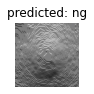

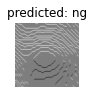

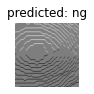

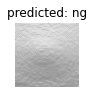

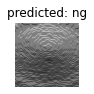

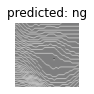

In [ ]:
visualize_model(model_ft)

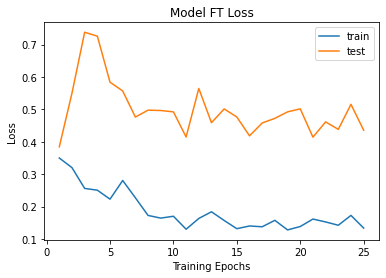

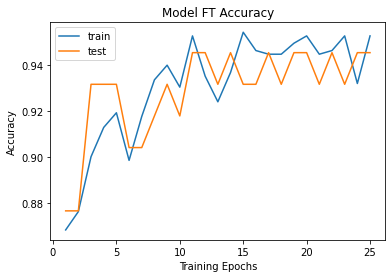

In [ ]:
import matplotlib.pyplot as plt

num_epochs = 25

# plot loss progress
plt.title("Model FT Loss")
plt.plot(range(1,num_epochs+1),loss_ft["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_ft["test"],label="test")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Model FT Accuracy")
plt.plot(range(1,num_epochs+1),acc_ft["train"],label="train")
plt.plot(range(1,num_epochs+1),acc_ft["test"],label="test")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()
